# Integrating Trajectories using OrdinaryDiffEq.jl
This notebook computes trajectories using the interface defined by OrdinaryDiffEq.jl. It goes over the dynamics functions.

### The first step is to import the ThreeBodyProblem and OrdinaryDiffEq packages. We'll also use Plots. 

In [1]:
@time using ThreeBodyProblem
@time using DifferentialEquations
@time using LinearAlgebra
@time using Plots

  0.289354 seconds (455.44 k allocations: 27.444 MiB, 2.71% gc time)
  8.510202 seconds (20.04 M allocations: 1.478 GiB, 5.96% gc time)
  0.000055 seconds (100 allocations: 7.891 KiB)
  4.678851 seconds (8.76 M allocations: 563.130 MiB, 3.92% gc time)


## Dynamics Equations
ThreeBodyProblem.jl implements the equations of motion for several models, including the Circular Restricted Three-Body Problem (CR3BP), Bicircular Problem (BCP), Restricted Two-Body Problem (R2BP), and Clohessy-Wiltshire (CW). 

### CR3BP
The CR3BP depends on a single parameter, the mass parameter μ. We can compute the time derivative of a state in the rotating frame with the CR3BPdynamics function

In [2]:
μ = 0.1 # arbitrary mass parameter
rv = [0.5, 0, 0, 0, 0.5, 0] # arbitrary state
t = 0 # time at which to evaluate the dynamics
rvdot = CR3BPdynamics(rv, μ, t) # time derivative of initial conditions

6-element Vector{Float64}:
  0.0
  0.5
  0.0
 -0.375
  0.0
 -0.0

We can also give it a vector of paramters p = [μ₁, μ₂, d]

In [3]:
μ₁ = G*EARTH.m # {km^3/s^2} gravitational parameter of Earth
μ₂ = G*MOON.m # {km^3/s^2} gravitational parameter of the Moon
d = MOON.a # {km} distance between Earth and Moon
p = [μ₁, μ₂, d] # parameter vector
rv = [1.5e5, 0, 0, 0, 10, 0] # initial conditions in dimensional units {km and km/s}
rvdot = CR3BPdynamics(rv, p, t) # time derivative of initial conditions

6-element Vector{Float64}:
  0.0
  0.5
  0.0
 -0.018266821881590307
  0.0
 -0.0

But the easiest way is to input a system

In [4]:
sys = earth_moon() # create a CR3BP system of the Earth and Moon
rv = [0.5, 0, 0, 0, 1, 0] # initial conditions in nondimensional units
rvdot = CR3BPdynamics(rv, sys, t) # initial conditions

6-element Vector{Float64}:
  0.0
  0.5
  0.0
 -2.215086557478187
  0.0
 -0.0

Note that the CR3BP is autonomous, so time doesn't appear in the equations of motion

In [5]:
CR3BPdynamics(rv, sys, t) == CR3BPdynamics(rv, sys, 10*t) ? "The time derivatives are equal" : "The time derivatives are not equal"

"The time derivatives are equal"

### Other Models
Each model has it's own required inputs

In [6]:
CR3BPinert(rv, sys, t) # CR3BP in the inertial frame (no longer autonomous)

w = [rv;reshape(I(6),36,1)] # initial conditions with the STM
CR3BPstm(w, sys, t) # CR3BP with the STM

sys_bcp = earth_moon_sun() # create a CR3BP system of the Earth, Moon, and Sun
BCPdynamics(rv, sys_bcp, t) # Bicircular Restricted Three Body Problem with the Sun as the Tertiary body



6-element Vector{Float64}:
  0.0
  0.5
  0.0
 -2.209480385153218
  0.0
 -0.0

## Setting up an ODEProblem
We will now create and solve an ODEProblem object that takes our dynamics function, initial condition, time-span, and system as inputs. 

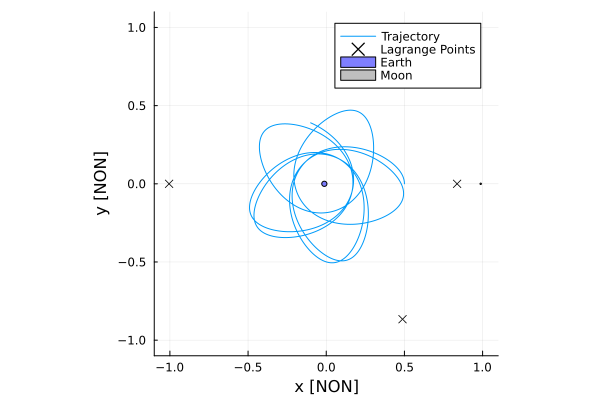

In [7]:
tspan = (0,10) # time span
prob = ODEProblem(CR3BPdynamics!, rv, tspan, sys) # create an ODEProblem
sol = solve(prob, TsitPap8(), reltol=1e-12, abstol=1e-12); # solve the ODEProblem
plot(sol, idxs=(1,2), xlabel="x [NON]", ylabel="y [NON]", label="Trajectory") # plot the solution
plot!(sys, lims=(-1.1, 1.1)) # plot the CR3BP system

## Lunar Return Trajectory
Let's compute a trajectory similar to that used by the Apollo missions. First we declare the parameters that describe the Earth-Moon system.

In [9]:
μ₁ = 398600 # {km³/s²} gravitational parameter of Earth
μ₂ = 4903   # {km³/s²} gravitational parameter of the Moon
d = 384400  # {km} average distance between Earth and the Moon

p = [μ₁, μ₂, d] # concatenate the parameters into one array

3-element Vector{Int64}:
 398600
   4903
 384400

We'll use the p vector so we can practice feeding that into the ODEProblem. Now let's define the initial condition of our spacecraft.

In [11]:
h = 200.0           # {km} altitude of parking orbit
vᵢ = 10.92367104    # {km/s} injection velocity in rotating frame
ϕ = 47.70061087     # {°} injection angle, measured from +y

Rₑ = 6378.0 # {km} radius of the Earth
Rₘ = 1738.0 # {km} radius of the Moon
d₁,d₂ = computed1d2(p) # {km} distances of Primary and Secondary bodies from origin
rₑ = [-d₁, 0, 0] # {km} position of the Earth
r₀ = rₑ + [-(Rₑ + 200)*cosd(ϕ); -(Rₑ + 200)*sind(ϕ); 0] # initial position of spacecraft in rotating frame
v₀ = vᵢ*[sind(ϕ); -cosd(ϕ); 0]; # initial velocity of spacecraft in rotating frame
rv₀ = [r₀;v₀] # {km; km/s} our initial state 

6-element Vector{Float64}:
 -9097.902229126237
 -4865.340542620438
     0.0
     8.07956515432666
    -7.3516811619605145
     0.0

### Integrate the trajectory

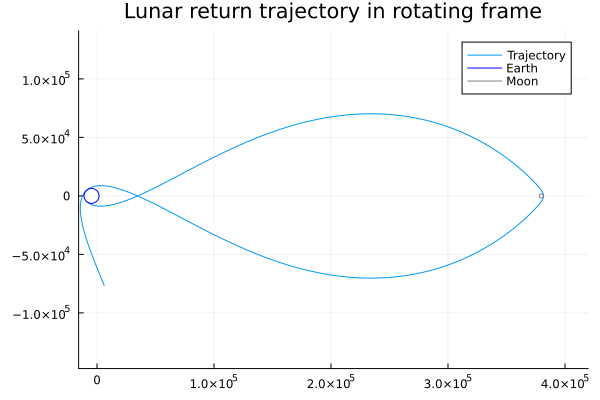

In [13]:
tspan = (0.,86400*6.) # {sec} 6 day span
prob = ODEProblem(CR3BPdynamics!, rv₀, tspan, p) # CR3BPdynamics! is our in-place dynamics function
sol = solve(prob, TsitPap8(), reltol=1e-6);

p_lun = plot(sol,vars=(1,2),title="Lunar return trajectory in rotating frame",label="Trajectory")
plot!(p_lun, circle(Rₑ,[-d₁;0]),color="blue",label="Earth")
plot!(p_lun, circle(Rₘ,[d₂;0]),color="gray",label="Moon",aspect_ratio=:equal)

We can use the animate() function to show the motion in time.

Plots.AnimatedGif("/home/jared711/.julia/dev/ThreeBodyProblemExamples.jl/tmp.gif")
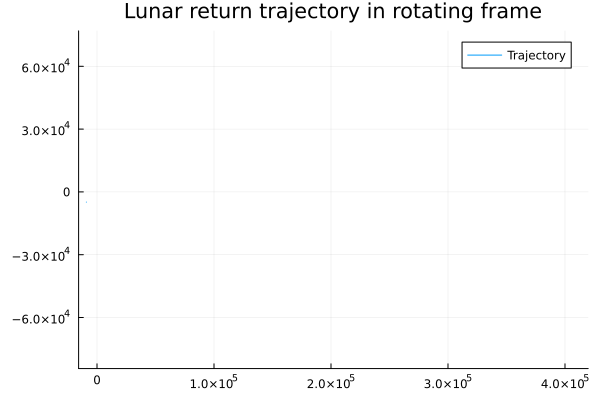

In [18]:
animate(sol,vars=(1,2),title="Lunar return trajectory in rotating frame",label="Trajectory")